In [36]:
import pandas as pd
from sklearn import linear_model, svm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from itertools import combinations
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from ipywidgets import interact
import ipywidgets as widgets
from sklearn.cross_validation import *
from copy import deepcopy
from pandas.io.json import json_normalize
from IPython.display import display, HTML
from scipy import interp
import pickle
%matplotlib notebook

In [37]:
pd.set_option('precision',4)

In [41]:
with open('Banco de Dados - Infarto.xlsx', 'rb') as xls_file:
    dataset = pd.read_excel(xls_file)
dataset['Desfecho'].replace(-1,0, inplace=True)
dataset.drop('Unnamed: 4', axis=1, inplace=True)
dataset.drop('Unnamed: 5', axis=1, inplace=True)

In [42]:
Y = dataset[['Desfecho']].as_matrix().T[0]
X = dataset.drop('Desfecho', axis=1)

## Banco de dados

In [43]:
# Verificando quantidade de elementos por classe
dataset.groupby(["Desfecho"])['Desfecho'].count()

Desfecho
0    583
1    291
Name: Desfecho, dtype: int64

## Preprocessamento

In [44]:
# Verificando existência de elementos nulo
dataset.isnull().values.any()

False

<IPython.core.display.Javascript object>


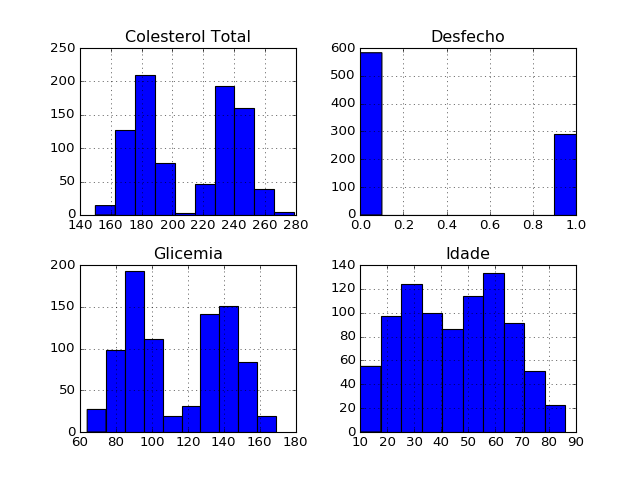

In [45]:
# Plotando histograma para escolher (se necessário) a melhor escala ou transformação dos dados
hist = pd.DataFrame.hist(dataset)

<IPython.core.display.Javascript object>


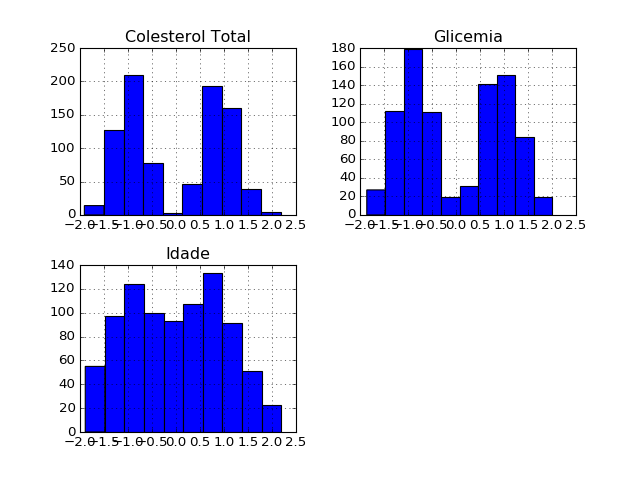

In [46]:
X_scaled = pd.DataFrame(preprocessing.scale(X), columns = X.columns)
hist = pd.DataFrame.hist(X_scaled)

## Treinamento

### Regularização

<IPython.core.display.Javascript object>


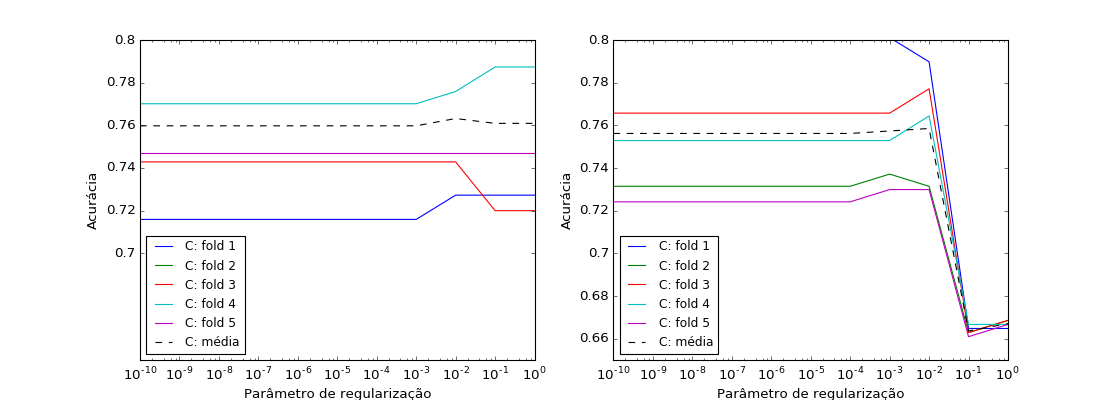

Higher mean accuracy at 0.76 for regularization parameter: 0.01000
Higher mean accuracy at 0.76 for regularization parameter: 0.01000


In [47]:
def scorer(model, x, y):
    #try:
    #    probabilities = model.predict_proba(x)
    #    probabilities = probabilities[:, 1]
    #except AttributeError:
    #    probabilities = model.predict(x)
        
    probabilities = model.predict(x)
    # Calcula ponto de corte a partir do treinamento
    #fpr, tpr, thresholds = roc_curve(y, probabilities)
        
    # Índice de Youden para calcular o ponto de corte ótimo
    #distance_idx = np.argmax(1-fpr+tpr)
    #thr = thresholds[distance_idx]
    
    #probabilities[probabilities > thr] = 1
    #probabilities[probabilities <= thr] = 0
    probabilities[probabilities > 0.5] = 1
    probabilities[probabilities <= 0.5] = 0
    
    return metrics.accuracy_score(y, probabilities)
    
    
def calculate_regularization(fig, position, model):
    C_s = np.logspace(-10, 0, 11)

    # Aplica k-fold estratificado
    kf = StratifiedKFold(Y, n_folds=5, shuffle=True)
    
    scores = list()
    scores_mean = list()
    scores_std = list()
    
    # Calcula o valor de acurácia para diferentes valores de regularização
    for C in C_s:
        if model == "Logreg":
            logreg = linear_model.LogisticRegression(penalty="l2")
            logreg.C = C
        else:
            logreg = linear_model.Lasso(alpha=C)
        this_scores = cross_val_score(logreg, X_scaled, Y, cv=kf, scoring=scorer)
    
        scores.append(this_scores)
        scores_mean.append(np.mean(this_scores))
        scores_std.append(np.std(this_scores))
    
    # Recupera a valor da regularização para o melhor valor de acurácia para a curva média
    best_c = C_s[np.asarray(scores_mean).argmax()]
    max_acc = np.asarray(scores_mean).max()
    print("Higher mean accuracy at %.2f for regularization parameter: %.5f" % (max_acc, best_c))
    
    scores_T = np.asarray(scores).T
    #y_max = np.asarray(scores).max()
    #y_min = np.asarray(scores).min()

    # Plot
    ax = fig.add_subplot(position)
    for i, score in enumerate(scores_T):
        # Plot each fold
        ax.semilogx(C_s, score, label='C: fold %d' % (i+1))
    
    # Plot valor médio
    ax.semilogx(C_s, scores_mean, 'k--', label='C: média')
    #plt.semilogx(C_s, np.array(scores_mean) + np.array(scores_std), 'b--')
    #plt.semilogx(C_s, np.array(scores_mean) - np.array(scores_std), 'b--')
    
    
    locs, labels = plt.yticks()
    plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
    ax.set_ylabel('Acurácia')
    ax.set_xlabel('Parâmetro de regularização')
    plt.legend(loc='lower left',prop={'size':11})
    plt.ylim(0.65, 0.8)
    
fig = plt.figure(figsize=(14,5))
calculate_regularization(fig, 121, 'Logreg')
calculate_regularization(fig, 122, 'Lasso')
plt.show()

In [48]:
# Função para treinamento dos dados
def train_data(fig, position, **kwargs):
    
    # Escolhe tipo de fold
    if kwargs["CV"] == "kfold":
        kf = KFold(len(X_scaled), n_folds=kwargs["n_folds"], shuffle=kwargs["shuffle"])
    elif kwargs["CV"] == "kfold_strat":
        kf = StratifiedKFold(Y, n_folds=kwargs["n_folds"], shuffle=kwargs["shuffle"])
    elif kwargs["CV"] == "loo":
        kf = LeaveOneOut(len(X_scaled))
    else:
        kf = [(range(len(X_scaled)-1), range(len(X_scaled)-1))]
             
    models = []
    train_idxs = []
    test_idxs = []
    thrs = []
    # Para cada fold, realiza treinamento
    for train_index, test_index in kf:
        X_train = X_scaled.loc[train_index]
        Y_train = Y[train_index]
        train_idxs.append(train_index)
        test_idxs.append(test_index)
        if kwargs["mode"] == 'Logreg':
            model = linear_model.LogisticRegression(C=kwargs["C"], penalty=kwargs["penalty"])
                                                #class_weight='balanced' if kwargs["balanced"] else {1: 1, 0: 1})
        elif kwargs["mode"] == 'Lasso':
            model = linear_model.Lasso(alpha=kwargs["C"])
            
        elif kwargs["mode"] == "SVM":
            model = svm.SVC(kernel=kwargs["kernel"])
            
        model.fit(X_train, Y_train)
        if kwargs["mode"] == 'Logreg':
            probabilities = model.predict_proba(X_train)
            probabilities = probabilities[:, 1]
        
        elif kwargs["mode"] == "Lasso":
            probabilities = model.predict(X_train)
            
        # Calcula ponto de corte a partir do treinamento
        fpr, tpr, thresholds = roc_curve(Y_train, probabilities)
        
        # Índice de Youden para calcular o ponto de corte ótimo
        distance_idx = np.argmax(1-fpr+tpr)
        thr = thresholds[distance_idx]
        
        if kwargs["display"]:
            print("Ponto de corte ótimo encontrado pela curva ROC em %.2f" % thr)
            
            
        models.append(model)
        thrs.append(thr)
        
    if kwargs["plot"]:
        plot_roc_curve(models, train_idxs, fig, thrs, position, **kwargs)
    return models, test_idxs, thrs

# Testa cada fold
def test_data(model, test_idxs, thr, **kwargs):
    # Métricas
    used_metrics = {
        "accuracy": [],
        "precision": {
            0: [],
            1: []
        },
        "recall": {
            0: [],
            1: []
        },
        "f1": {
            0: [],
            1: []
        }
    }
    predicted = {}
    frames_type = {"roc": [], "acc": []}
    
    for idx, model_item in enumerate(model):  
        results = {"roc": deepcopy(used_metrics), "acc": deepcopy(used_metrics)}
        if kwargs["mode"] == "Logreg":
            probabilities = model_item.predict_proba(X_scaled.loc[test_idxs[idx]])
            probabilities = probabilities[:, 1]
        
        elif kwargs["mode"] == "Lasso":
            probabilities = model_item.predict(X_scaled.loc[test_idxs[idx]])
        
        # Calcula curva ROC para cada item
        fpr, tpr, thresholds = roc_curve(Y[test_idxs[idx]], probabilities)
        
        # Classifica os dados de acordo com o ponto de corte
        predicted["roc"] = deepcopy(probabilities)
        predicted["roc"][predicted["roc"] > thr[idx]] = 1
        predicted["roc"][predicted["roc"] <= thr[idx]] = 0
       
        # Utiliza o ponto de corte de probabilidade média (0.5), para cálculo da acurácia
        predicted["acc"] = deepcopy(probabilities)
        predicted["acc"][predicted["acc"] > 0.5] = 1
        predicted["acc"][predicted["acc"] <= 0.5] = 0
        
        # Calcula métricas
        frames = []
        for key in results:
            cm = metrics.confusion_matrix(Y[test_idxs[idx]], predicted[key])
            if key == "acc" or kwargs["mean"] == "acc":
                results[key]["accuracy"] = (cm[0][0] + cm[1][1])/cm.sum()
            else:
                results[key]["accuracy"] = auc(fpr, tpr)
            for item in [(0,1),(1,0)]:
                results[key]["recall"][item[0]] = cm[item[0]][item[0]]/(cm[item[0]][item[0]]+cm[item[0]][item[1]])
                results[key]["precision"][item[0]] = cm[item[0]][item[0]]/(cm[item[0]][item[0]]+cm[item[1]][item[0]])
                results[key]["f1"][item[0]] = 2 * results[key]["precision"][item[0]] * results[key]["recall"][item[0]] / (
                    results[key]["precision"][item[0]] + results[key]["recall"][item[0]])
            recall_sum = sum(results[key]["recall"].values())
            if kwargs["display"]:
                print("Soma do recall para %s: %.4f" %(key, recall_sum))
                
            frames_type[key].append(json_normalize(results[key]))
            frames.append(json_normalize(results[key]))
        df_results = pd.concat(frames, keys=results.keys())
        if kwargs["display"]:
            display(df_results)
        
    # Média dos folds
    df_mean_results = []
    for key in results:
        df_results = pd.concat(frames_type[key], keys=["Fold %d" % i for i in range(1,kwargs["n_folds"]+1)])
        df_mean_results.append(df_results.mean().rename(key).to_frame())
    df_results = df_mean_results[0].merge(df_mean_results[1], how="outer", left_index=True, right_index=True)

    if kwargs["display"]:
        display(df_results)
    return (results["roc"]["accuracy"], results["acc"]["accuracy"])
        
        
            
# Exibe relatório (acurácia com threshold = 0.5)
def print_report(model, test_idxs, **kwargs):
    for idx, model_item in enumerate(model):
        Z = model_item.predict(X_scaled.loc[test_idxs[idx]])
        Z_predicted = pd.DataFrame(Z.round(), columns = ["Desfecho"])
        print(metrics.classification_report(Y[test_idxs[idx]], Z_predicted))
    return

# Exibe plots
def manage_plots(model, test_idxs, fig, thr, position, **kwargs):
    #position = [kwargs["n_folds"],2,1]
    plot_roc_curve(model, test_idxs, fig, thr, position, **kwargs)
    #for idx, model_item in enumerate(model):
    #    Z = model_item.predict(X_scaled.loc[test_idxs[idx]])
    #    Z_predicted = pd.DataFrame(Z.round(), columns = ['Desfecho'])
        #plot_curves(model_item, fig, position, X_scaled.loc[test_idxs[idx]], Y[test_idxs[idx]])
    #    position[2] += 1
    #    plot_confusion_matrix_wrapper(Z_predicted, fig, np.unique(Y), position, Y[test_idxs[idx]])
    #    position[2] += 1    

In [80]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def plot_roc_curve(model, test_idxs, fig, thr, position, **kwargs):

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, len(test_idxs[0]))

    #fig = plt.figure(figsize=(10,5))
    fig.add_subplot(position[0], position[1], position[2])
    
    for idx, model_item in enumerate(model):  
        if kwargs["mode"] == "Logreg":
            probabilities = model_item.predict_proba(X_scaled.loc[test_idxs[idx]])
            probabilities = probabilities[:, 1]
        
        elif kwargs["mode"] == "Lasso":
            probabilities = model_item.predict(X_scaled.loc[test_idxs[idx]])
        
        # Calcula curva ROC para cada item
        fpr, tpr, thresholds = roc_curve(Y[test_idxs[idx]], probabilities)
        
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (área = %0.2f)' % ((idx+1), roc_auc))
        
        probs = [0.5, thr[idx]]
        half_prob = find_nearest(thresholds, probs[0])
        best_prob = find_nearest(thresholds, probs[1])
        plt.plot(fpr[half_prob], tpr[half_prob], 'or')
        plt.plot(fpr[best_prob], tpr[best_prob], 'ob')


    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Aleatório')

    mean_tpr /= len(model)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='ROC Média (área = %0.2f)' % mean_auc, lw=2)
    plt.plot(fpr[half_prob], tpr[half_prob], 'or', label="Corte = 0.5")
    plt.plot(fpr[best_prob], tpr[best_prob], 'ob', label="Corte = %.2f" % thr[idx])
    
#    if len(model) == 1:
    
    for i, item in enumerate(((fpr[half_prob], tpr[half_prob]), (fpr[best_prob], tpr[best_prob]))):
        plt.annotate(
                "%.2f" % probs[i], 
                xy = (item[0], item[1]), xytext = (-20, 20),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Taxa de falsos positivos')
    plt.ylabel('Taxa de verdadeiros positivos')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", prop={"size":9})


In [50]:
def run(**kwargs):
    if (kwargs["n_folds"] > 1):
        position = (1,2,1)
    else:
        position = (1,1,1)
    fig = None
    if kwargs["plot"]:
        fig = plt.figure(figsize=(position[1]*5,5))
    model, test_idxs, thr = train_data(fig, position, **kwargs)
    (roc, acc) = test_data(model, test_idxs, thr, **kwargs)
    #return results
    
    #if kwargs["CV"] != "loo":
     #   print_report(model, test_idxs, **kwargs)
    if kwargs["plot"]:
        if (kwargs["n_folds"] > 1):
            position = (1,2,2)
            #fig = plt.figure(figsize=(10,5*kwargs["n_folds"]))
            manage_plots(model, test_idxs, fig, thr, position, **kwargs)
        plt.show()
    final_model = {"model": model, "threshold": thr}
    return (roc,acc, final_model)

<IPython.core.display.Javascript object>


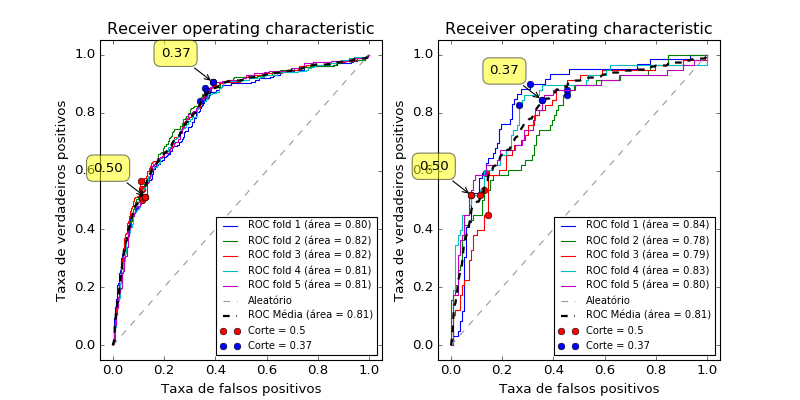

Ponto de corte ótimo encontrado pela curva ROC em 0.39
Ponto de corte ótimo encontrado pela curva ROC em 0.38
Ponto de corte ótimo encontrado pela curva ROC em 0.38
Ponto de corte ótimo encontrado pela curva ROC em 0.40
Ponto de corte ótimo encontrado pela curva ROC em 0.37
Soma do recall para roc: 1.5735
Soma do recall para acc: 1.4565


accuracy    f1.0    f1.1  precision.0  precision.1  recall.0  recall.1
roc 0    0.7500  0.7822  0.7067       0.9294       0.5824    0.6752    0.8983
acc 0    0.7727  0.8347  0.6364       0.8080       0.6863    0.8632    0.5932

Soma do recall para roc: 1.4091
Soma do recall para acc: 1.3718


accuracy    f1.0    f1.1  precision.0  precision.1  recall.0  recall.1
roc 0    0.6514  0.6772  0.6211       0.8889       0.4854    0.5470    0.8621
acc 0    0.7486  0.8226  0.5686       0.7786       0.6591    0.8718    0.5000

Soma do recall para roc: 1.4436
Soma do recall para acc: 1.3115


accuracy    f1.0   f1.1  precision.0  precision.1  recall.0  recall.1
roc 0    0.6629  0.6845  0.638       0.9143       0.4952    0.5470    0.8966
acc 0    0.7257  0.8080  0.520       0.7594       0.6190    0.8632    0.4483

Soma do recall para roc: 1.5259
Soma do recall para acc: 1.4138


accuracy    f1.0    f1.1  precision.0  precision.1  recall.0  recall.1
roc 0    0.7529  0.7981  0.6815       0.8763       0.5974    0.7328    0.7931
acc 0    0.7701  0.8387  0.6000       0.7879       0.7143    0.8966    0.5172

Soma do recall para roc: 1.4741
Soma do recall para acc: 1.4483


accuracy    f1.0    f1.1  precision.0  precision.1  recall.0  recall.1
roc 0    0.7069  0.7463  0.6531       0.8824       0.5393    0.6466    0.8276
acc 0    0.7931  0.8571  0.6250       0.7941       0.7895    0.9310    0.5172

roc     acc
accuracy     0.7048  0.7620
f1.0         0.7377  0.8322
f1.1         0.6601  0.5900
precision.0  0.8982  0.7856
precision.1  0.5400  0.6936
recall.0     0.6297  0.8852
recall.1     0.8555  0.5152

(0.7068965517241379,
 0.7931034482758621,
 {'model': [LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False),
   LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False),
   LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False),
   LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=

In [51]:
interact(run, **{"mode": ["Logreg", "Lasso", "SVM"], "C":widgets.FloatSlider(min=1e-3,max=10,step=1e-3, value=0.01,
                                                           continuous_update=False), 
                 "penalty": ["l2", "l1"], "balanced": False, "n_folds": 5, "shuffle": True, 
                 "CV": ["kfold_strat", "kfold", "", "loo"], "plot": False,
                "kernel": ["linear", "rbf", "poly", "sigmoid"], "display": True,
                "mean": ["acc", "roc"]}, 
         __manual=True)

### Comparação entre modelos e métricas

In [52]:
%%time
roc = {"Logreg": [], "Lasso": []}
acc = {"Logreg": [], "Lasso": []}
C = {"Logreg": 0.01, "Lasso": 0.001}
for mode in ["Logreg", "Lasso"]:
    for i in range(0,100):
        roc_item, acc_item, _ = run(**{"mode": mode, "C": C[mode], "penalty": "l2", "n_folds": 5, "shuffle": True, 
                          "CV": "kfold_strat", "plot": False, "balanced": False, "display": False, "mean": "roc"})
        roc[mode].append(roc_item)
        acc[mode].append(acc_item)

roc_pd = pd.DataFrame(roc)
acc_pd = pd.DataFrame(acc)
roc_mean = roc_pd.mean()
roc_std = roc_pd.std()
acc_mean = acc_pd.mean()
acc_std = acc_pd.std()

roc_combined = pd.concat([roc_mean, roc_std], axis=1)
roc_combined.columns = ["Media ROC", "Std ROC"]
acc_combined = pd.concat([acc_mean, acc_std], axis=1)
acc_combined.columns = ["Media Acc", "Std Acc"]

summary = pd.concat([roc_combined, acc_combined], axis=1)

display(summary)

Media ROC  Std ROC  Media Acc  Std Acc
Lasso      0.8100   0.0317     0.7617   0.0237
Logreg     0.8099   0.0279     0.7558   0.0234

CPU times: user 9.68 s, sys: 13.2 ms, total: 9.69 s
Wall time: 9.7 s


### Treinamento do modelo final (utilizando todos os dados)

<IPython.core.display.Javascript object>


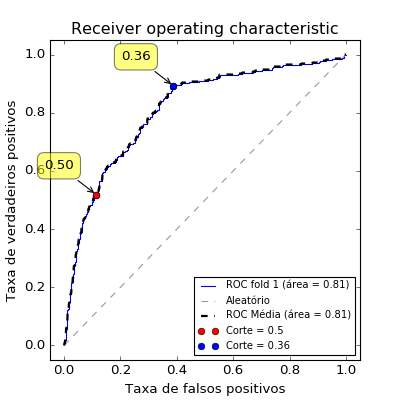

Ponto de corte ótimo encontrado pela curva ROC em 0.36
Soma do recall para roc: 1.5034
Soma do recall para acc: 1.4072


accuracy    f1.0    f1.1  precision.0  precision.1  recall.0  recall.1
roc 0    0.8127  0.7353  0.6684       0.9177       0.5351    0.6134    0.8900
acc 0    0.7652  0.8345  0.5957       0.7869       0.6991    0.8883    0.5189

roc     acc
accuracy     0.8127  0.7652
f1.0         0.7353  0.8345
f1.1         0.6684  0.5957
precision.0  0.9177  0.7869
precision.1  0.5351  0.6991
recall.0     0.6134  0.8883
recall.1     0.8900  0.5189

In [79]:
roc, acc, model = run(**{"mode": "Logreg", "C": 0.01, "penalty": "l2", "n_folds": 1, "shuffle": True, 
                         "CV": "", "plot": True, "balanced": False, "display": True, "mean": "roc"})

model["model"] = model["model"][0]
model["threshold"] = model["threshold"][0]
model["mean"] = X.mean(axis=0)
model["std"] = X.std(axis=0)
with open('model.pkl', 'wb') as pkl_file:
    pickle.dump(model, pkl_file)

## Visualização dos dados

In [142]:
def plot_attack2d(X1, X2, position, x, y):
    ax2 = fig.add_subplot(position)
    ax2.scatter(X1[[x]], X1[[y]], c='b', marker='^')
    ax2.scatter(X2[[x]], X2[[y]], c='r', marker='o')
    ax2.set_xlabel(x)
    ax2.set_ylabel(y)
    
def plot_all2d(X1, X2):
    position = 331
    for item in combinations(X1.columns, 2):
        plot_attack2d(X1, X2, position, item[0], item[1])
        position += 1
    plt.show()

### Visualização dos dados originais

<IPython.core.display.Javascript object>


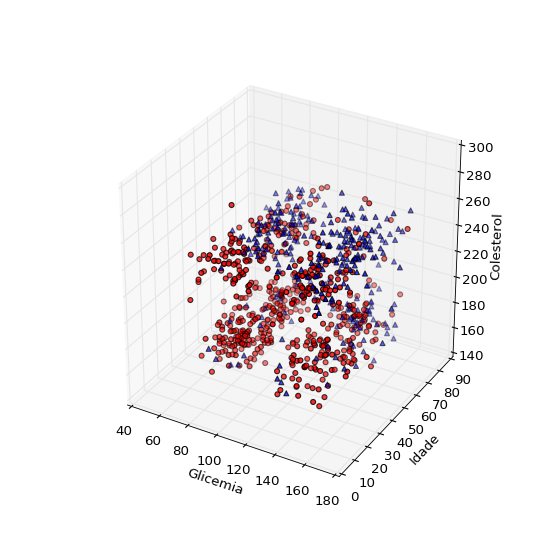

In [143]:
# Plot the training points
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')

X1 = X[dataset["Desfecho"] == 1]
X2 = X[dataset["Desfecho"] == 0]
ax1.scatter(X1[["Glicemia"]], X1[["Idade"]], X1[["Colesterol Total"]], c='b', marker='^')
ax1.scatter(X2[["Glicemia"]], X2[["Idade"]], X2[["Colesterol Total"]], c='r', marker='o')

ax1.set_xlabel('Glicemia')
ax1.set_ylabel('Idade')
ax1.set_zlabel('Colesterol')



plt.show()

<IPython.core.display.Javascript object>


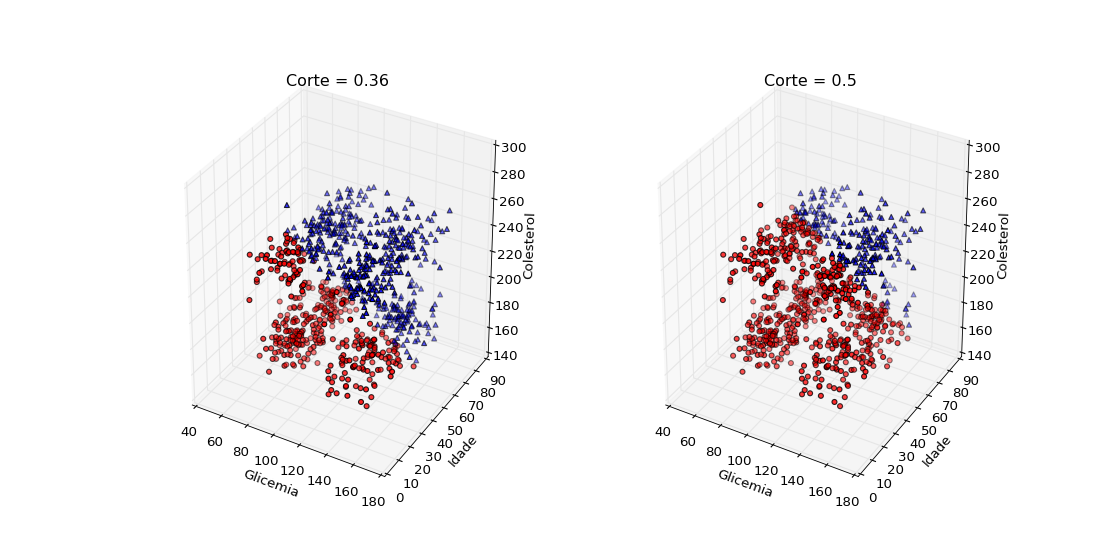

In [150]:
# Plot the training points
fig = plt.figure(figsize=(14,7))
ax2 = fig.add_subplot(121, projection='3d')

Z_predicted = model["model"].predict_proba(X_scaled)
Z_predicted = Z_predicted[:,1]
Z_predicted[Z_predicted > model["threshold"]] = 1
Z_predicted[Z_predicted <= model["threshold"]] = 0

X1 = X[Z_predicted == 1]
X2 = X[Z_predicted == 0]
ax2.scatter(X1[["Glicemia"]], X1[["Idade"]], X1[["Colesterol Total"]], c='b', marker='^')
ax2.scatter(X2[["Glicemia"]], X2[["Idade"]], X2[["Colesterol Total"]], c='r', marker='o')

ax2.set_xlabel('Glicemia')
ax2.set_ylabel('Idade')
ax2.set_zlabel('Colesterol')
plt.title("Corte = %.2f" % (model["threshold"]))

ax3 = fig.add_subplot(122, projection='3d')

Z_predicted = model["model"].predict(X_scaled)
#Z_predicted = Z_predicted[:,1]
#Z_predicted[Z_predicted > model["threshold"]] = 1
#Z_predicted[Z_predicted <= model["threshold"]] = 0

X1 = X[Z_predicted == 1]
X2 = X[Z_predicted == 0]
ax3.scatter(X1[["Glicemia"]], X1[["Idade"]], X1[["Colesterol Total"]], c='b', marker='^')
ax3.scatter(X2[["Glicemia"]], X2[["Idade"]], X2[["Colesterol Total"]], c='r', marker='o')

ax3.set_xlabel('Glicemia')
ax3.set_ylabel('Idade')
ax3.set_zlabel('Colesterol')
plt.title("Corte = 0.5")

plt.show()

<IPython.core.display.Javascript object>


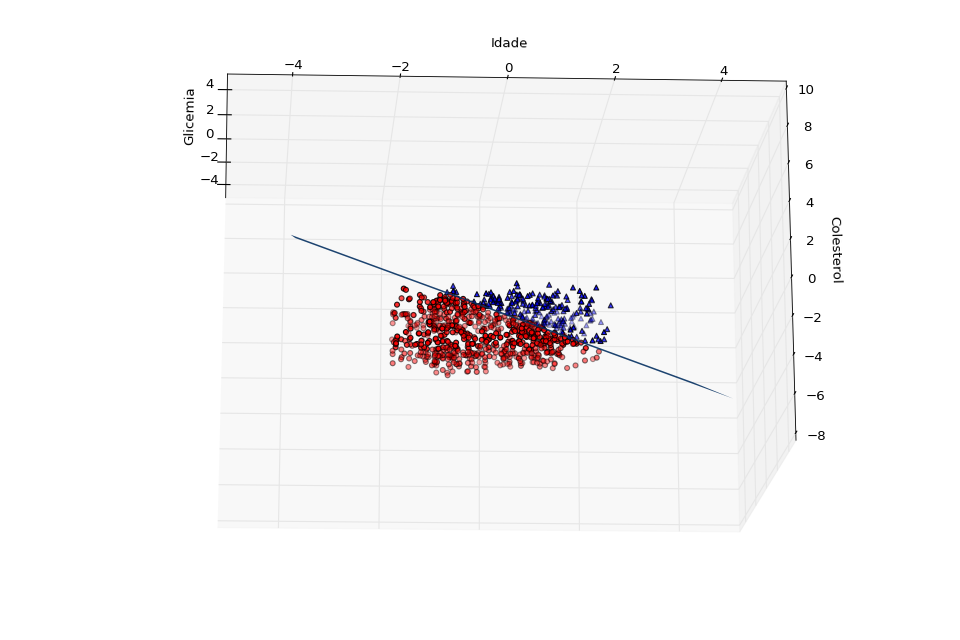

In [154]:
xx1, xx2 = np.meshgrid(np.linspace(X_scaled.Glicemia.min()-2, X_scaled.Glicemia.max()+2, 10), 
                       np.linspace(X_scaled.Idade.min()-2, X_scaled.Idade.max()+2, 10))

# get the separating hyperplane
# 0 = Colesterol
# 1 = Idade
# 2 = Glicemia
zz = -(model["model"].intercept_ + model["model"].coef_[0][2] * xx1 + model["model"].coef_[0][1] * xx2)/model["model"].coef_[0][0]

X1 = X_scaled[Z_predicted == 1]
X2 = X_scaled[Z_predicted == 0]

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax1 = Axes3D(fig, azim=0, elev=0)

# plot hyperplane
surf = ax1.plot_surface(xx1, xx2, zz, cmap=plt.cm.RdBu_r, alpha=0.9, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = model["model"].decision_function(X_scaled)
ax1.scatter(X1["Glicemia"], X1["Idade"], X1["Colesterol Total"], c='b', marker='^')
ax1.scatter(X2["Glicemia"], X2["Idade"], X2["Colesterol Total"], c='r', marker='o')

ax1.set_xlabel('Glicemia')
ax1.set_ylabel('Idade')
ax1.set_zlabel('Colesterol')


plt.show()

In [ ]:
def plot_confusion_matrix(ax, cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_confusion_matrix_wrapper(Z_predicted, fig, classes, position, Y):
    # Compute confusion matrix
    cm = metrics.confusion_matrix(Y, Z_predicted)
    np.set_printoptions(precision=2)
    #print('Confusion matrix')
    #print(cm)
    #plt.figure()
    ax = fig.add_subplot(position[0], position[1], position[2])
    plot_confusion_matrix(ax, cm, classes)
    ax.text(-0.1,0,cm[0][0], fontsize=15, color='white')
    ax.text(0.9,0,cm[0][1], fontsize=15, color='black')
    ax.text(-0.1,1,cm[1][0], fontsize=15, color='black')
    ax.text(0.9,1,cm[1][1], fontsize=15, color='black')
    plt.show()


# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(cm_normalized)
#plt.figure()
#plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

#plt.show()
#print(metrics.accuracy_score(Y, Z_predicted))
#print(metrics.average_precision_score(Y, Z_predicted, average='macro'))
#print(metrics.precision_score(Y, Z_predicted))
#print(metrics.f1_score(Y, Z_predicted))
##print(metrics.f1_score(Y, Z_predicted, average='micro'))
#print(metrics.f1_score(Y, Z_predicted, average='macro'))
#print(metrics.f1_score(Y, Z_predicted, average='weighted'))
#print(metrics.log_loss(Y, logreg.predict_proba(X_scaled)))
#print(metrics.classification_report(Y, Z_predicted))

In [ ]:
# Compute Precision-Recall and plot curve
def plot_curves(model, fig, position, X, Y):
    precision = dict()
    recall = dict()
    average_precision = dict()

    decision = model.decision_function(X)
    classes = np.unique(Y)
    
    Y_train = [None, None]
    for idx, i in enumerate(classes):
        Y_train[idx] = (Y==i).astype(int)

    for idx,i in enumerate(classes):
        precision[i], recall[i], _ = metrics.precision_recall_curve(Y_train[idx], decision * -1)
        average_precision[i] = metrics.average_precision_score(Y_train[idx], decision * -1)
    # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(Y.ravel(), decision.ravel())
    average_precision["micro"] = metrics.average_precision_score(Y, decision, average="micro")

    # Plot Precision-Recall curve for each class
    #plt.figure()
    #plt.clf()
    ax = fig.add_subplot(position[0], position[1], position[2])
    ax.plot(recall["micro"], precision["micro"],
             label='Global P-R curve (area = {0:0.2f})'
                   ''.format(average_precision["micro"]))
    for i in classes:
        ax.plot(recall[i], precision[i],
                 label='class {0} P-R curve (area = {1:0.2f})'
                       ''.format(i, average_precision[i]))
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right", prop={'size':9})
    #plt.show()